In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

DATA_DIR = Path("walmart") 

train = pd.read_csv(DATA_DIR/"train.csv")
test = pd.read_csv(DATA_DIR/"test.csv")
features = pd.read_csv(DATA_DIR/"features.csv")
stores = pd.read_csv(DATA_DIR/"stores.csv")

print(train.head())
print(features.head())
print(stores.head())


   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False
   Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        39.93       2.514        NaN        NaN   
3      1  2010-02-26        46.63       2.561        NaN        NaN   
4      1  2010-03-05        46.50       2.625        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0        NaN        NaN        NaN  211.096358         8.106      False  
1        NaN        NaN        NaN  211.242170         8.106       True  
2        NaN        NaN        NaN  211

In [2]:
print(train.isna().sum())
print(features.isna().sum())
print(stores.isna().sum())


Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64
Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64
Store    0
Type     0
Size     0
dtype: int64


In [3]:
# Fill MarkDowns with 0
markdown_cols = ["MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5"]
features[markdown_cols] = features[markdown_cols].fillna(0)

# Fill CPI & Unemployment with forward/backward fill
features["CPI"] = features["CPI"].fillna(method="ffill").fillna(method="bfill")
features["Unemployment"] = features["Unemployment"].fillna(method="ffill").fillna(method="bfill")


In [4]:
train_full = train.merge(features, on=["Store","Date","IsHoliday"], how="left")
train_full = train_full.merge(stores, on="Store", how="left")


In [5]:
print(train_full.head())

   Store  Dept        Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1     1  2010-02-05      24924.50      False        42.31       2.572   
1      1     1  2010-02-12      46039.49       True        38.51       2.548   
2      1     1  2010-02-19      41595.55      False        39.93       2.514   
3      1     1  2010-02-26      19403.54      False        46.63       2.561   
4      1     1  2010-03-05      21827.90      False        46.50       2.625   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        0.0        0.0        0.0        0.0        0.0  211.096358   
1        0.0        0.0        0.0        0.0        0.0  211.242170   
2        0.0        0.0        0.0        0.0        0.0  211.289143   
3        0.0        0.0        0.0        0.0        0.0  211.319643   
4        0.0        0.0        0.0        0.0        0.0  211.350143   

   Unemployment Type    Size  
0         8.106    A  151315  
1         8.106    A  15

In [6]:
train_full["Date"] = pd.to_datetime(train_full["Date"])

# Aggregate to monthly sales
monthly_sales = (train_full
    .set_index("Date")
    .resample("M")["Weekly_Sales"]
    .sum()
    .reset_index()
    .rename(columns={"Weekly_Sales": "Total_Sales"})
)



In [10]:
# Add Month column
monthly_sales["Month"] = monthly_sales["Date"].dt.month

# Group by month to calculate average sales
seasonality = monthly_sales.groupby("Month")["Total_Sales"].mean()

## Monthly Sales Trend 

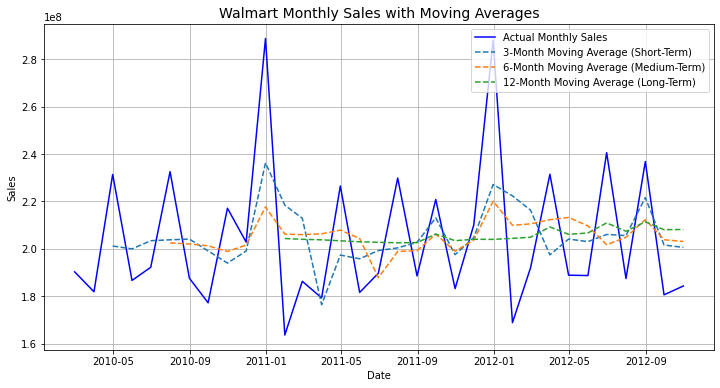

In [7]:
import matplotlib.pyplot as plt

monthly_sales["MA_3"] = monthly_sales["Total_Sales"].rolling(3).mean()
monthly_sales["MA_6"] = monthly_sales["Total_Sales"].rolling(6).mean()
monthly_sales["MA_12"] = monthly_sales["Total_Sales"].rolling(12).mean()

plt.figure(figsize=(12,6))

plt.plot(monthly_sales["Date"], monthly_sales["Total_Sales"], label="Actual Monthly Sales", color="blue")
plt.plot(monthly_sales["Date"], monthly_sales["MA_3"], label="3-Month Moving Average (Short-Term)", linestyle="--")
plt.plot(monthly_sales["Date"], monthly_sales["MA_6"], label="6-Month Moving Average (Medium-Term)", linestyle="--")
plt.plot(monthly_sales["Date"], monthly_sales["MA_12"], label="12-Month Moving Average (Long-Term)", linestyle="--")

plt.title("Walmart Monthly Sales with Moving Averages", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()

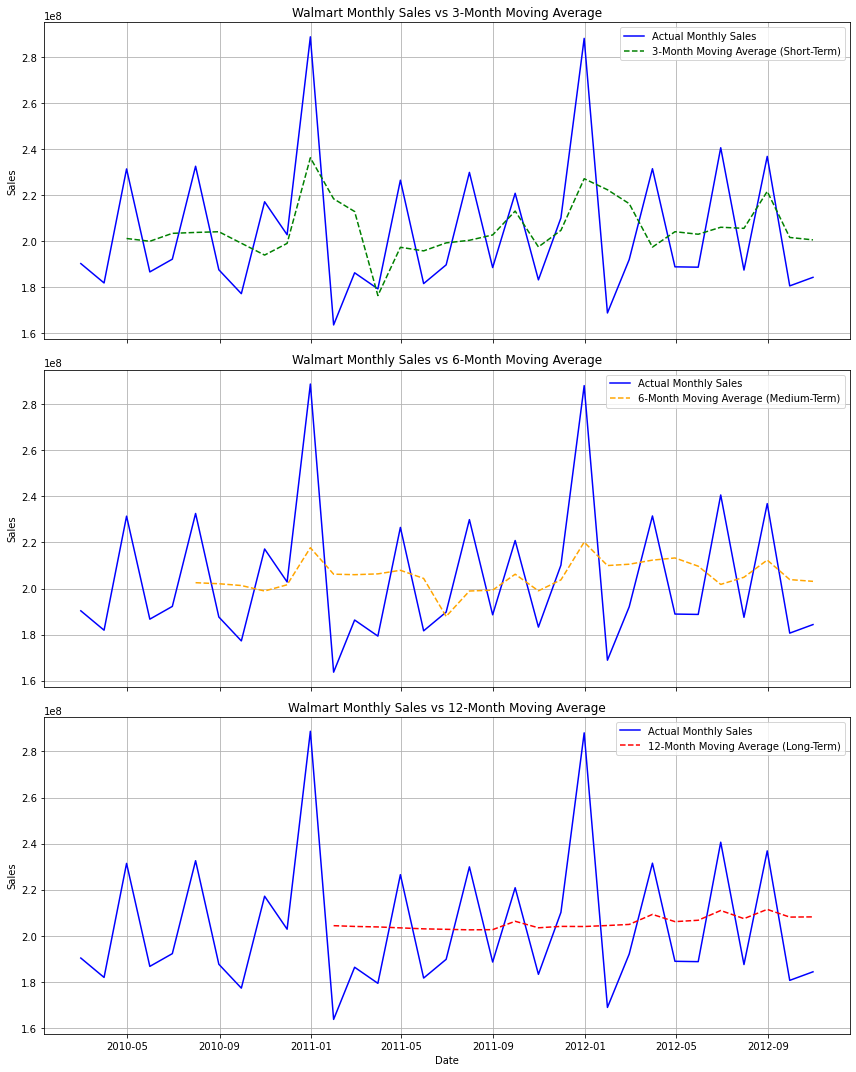

In [8]:
fig, axes = plt.subplots(3, 1, figsize=(12, 15), sharex=True)

# Plot 3-Month MA
axes[0].plot(monthly_sales["Date"], monthly_sales["Total_Sales"], label="Actual Monthly Sales", color="blue")
axes[0].plot(monthly_sales["Date"], monthly_sales["MA_3"], label="3-Month Moving Average (Short-Term)", color="green", linestyle="--")
axes[0].set_title("Walmart Monthly Sales vs 3-Month Moving Average")
axes[0].set_ylabel("Sales")
axes[0].legend()
axes[0].grid(True)

# Plot 6-Month MA
axes[1].plot(monthly_sales["Date"], monthly_sales["Total_Sales"], label="Actual Monthly Sales", color="blue")
axes[1].plot(monthly_sales["Date"], monthly_sales["MA_6"], label="6-Month Moving Average (Medium-Term)", color="orange", linestyle="--")
axes[1].set_title("Walmart Monthly Sales vs 6-Month Moving Average")
axes[1].set_ylabel("Sales")
axes[1].legend()
axes[1].grid(True)

# Plot 12-Month MA
axes[2].plot(monthly_sales["Date"], monthly_sales["Total_Sales"], label="Actual Monthly Sales", color="blue")
axes[2].plot(monthly_sales["Date"], monthly_sales["MA_12"], label="12-Month Moving Average (Long-Term)", color="red", linestyle="--")
axes[2].set_title("Walmart Monthly Sales vs 12-Month Moving Average")
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Sales")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()


## Seasonality

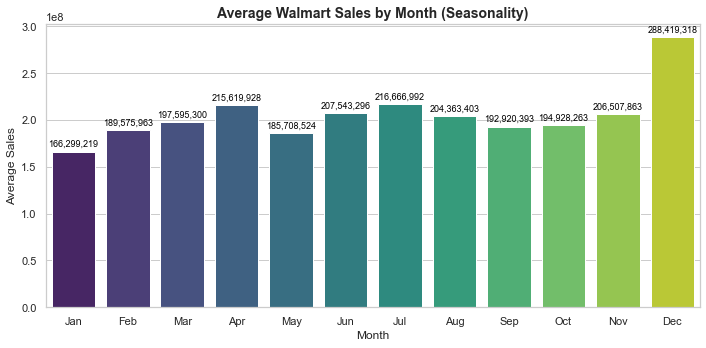

In [11]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(10,5))
ax = sns.barplot(x=seasonality.index, y=seasonality.values, palette="viridis")

plt.title("Average Walmart Sales by Month (Seasonality)", fontsize=14, fontweight="bold")
plt.xlabel("Month", fontsize=12)
plt.ylabel("Average Sales", fontsize=12)

# Show month names instead of numbers
month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
               "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
ax.set_xticklabels(month_names)

for p in ax.patches:
    ax.annotate(f"{p.get_height():,.0f}", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=9, color="black", xytext=(0,3), textcoords="offset points")

plt.tight_layout()
plt.show()


### Revenue by Product over Time

<Figure size 1008x576 with 0 Axes>

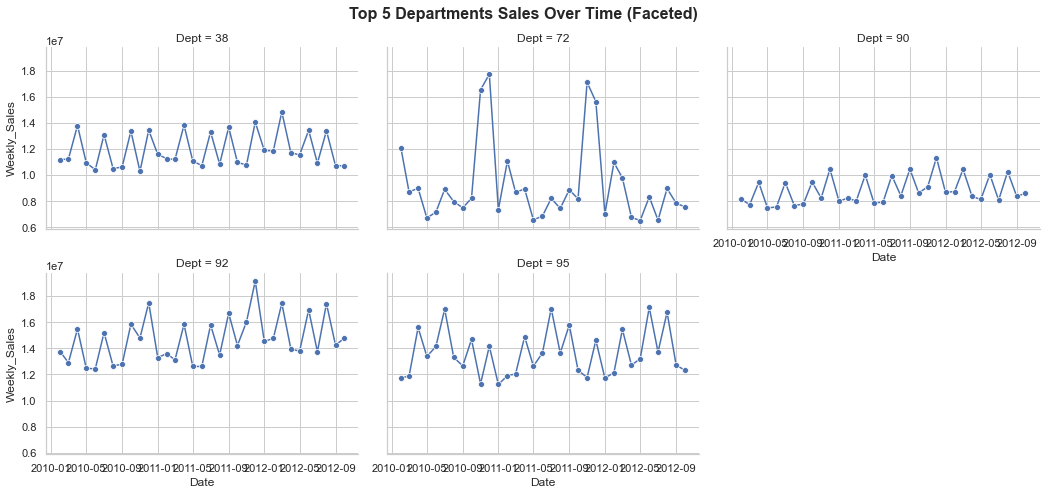

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# -----------------------------
# By Department (Top 5)
# -----------------------------
dept_monthly = (
    train_full.groupby(["Dept", pd.Grouper(key="Date", freq="MS")])["Weekly_Sales"]
    .sum()
    .reset_index()
)

#top 5 depts overall
top_depts = dept_monthly.groupby("Dept")["Weekly_Sales"].sum().nlargest(5).index
filtered = dept_monthly[dept_monthly["Dept"].isin(top_depts)]

plt.figure(figsize=(14,8))
sns.relplot(
    data=filtered,
    x="Date", y="Weekly_Sales",
    col="Dept",  # separate subplot per dept
    kind="line", col_wrap=3,
    height=3.5, aspect=1.4,
    marker="o"
)

plt.subplots_adjust(top=0.9)
plt.suptitle("Top 5 Departments Sales Over Time (Faceted)", fontsize=16, fontweight="bold")
plt.show()



### Revenue by Region over Time

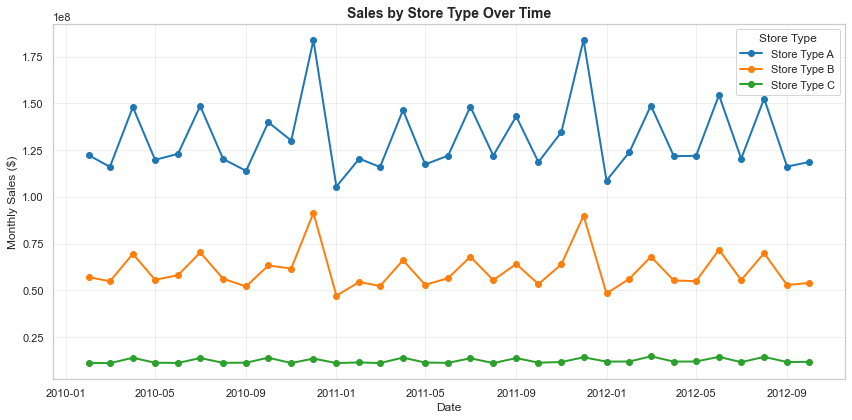

In [13]:

# -----------------------------
# By Store Type (A, B, C)
# -----------------------------
type_monthly = (
    train_full.groupby(["Type", pd.Grouper(key="Date", freq="MS")])["Weekly_Sales"]
    .sum()
    .reset_index()
)

plt.figure(figsize=(12,6))
palette = {"A":"#1f77b4", "B":"#ff7f0e", "C":"#2ca02c"}
for t in type_monthly["Type"].unique():
    subset = type_monthly[type_monthly["Type"]==t]
    plt.plot(subset["Date"], subset["Weekly_Sales"], marker="o", linewidth=2,
             color=palette[t], label=f"Store Type {t}")

plt.title("Sales by Store Type Over Time", fontsize=14, fontweight="bold")
plt.xlabel("Date")
plt.ylabel("Monthly Sales ($)")
plt.legend(title="Store Type")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Forecasting

Next month forecast (MA-3): 200619330.19
Next month forecast (EWMA α=0.3): 198409756.71


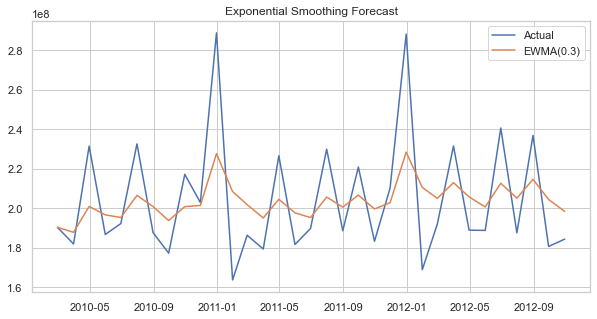

In [14]:
# Rolling mean forecast (last 3 months)
ma3_forecast = monthly_sales["MA_3"].iloc[-1]
print("Next month forecast (MA-3):", round(ma3_forecast,2))

# Exponential Smoothing (EWMA)
monthly_sales["EWMA"] = monthly_sales["Total_Sales"].ewm(alpha=0.3, adjust=False).mean()
ewma_forecast = monthly_sales["EWMA"].iloc[-1]
print("Next month forecast (EWMA α=0.3):", round(ewma_forecast,2))

plt.figure(figsize=(10,5))
plt.plot(monthly_sales["Date"], monthly_sales["Total_Sales"], label="Actual")
plt.plot(monthly_sales["Date"], monthly_sales["EWMA"], label="EWMA(0.3)")
plt.title("Exponential Smoothing Forecast")
plt.legend(); plt.show()
